# Visualization w/ Plotly (in Python)

By: [Paul Jeffries](https://twitter.com/ByPaulJ) 

**NOTE: this is an early work in progress. Check back shortly for new additions.**

## Setup 

In [11]:
# basic packages
import pandas as pd
import numpy as np
import datetime

# for data importing
import os
import csv

# for visualizing
import plotly_express as px

# for data cleaning
from janitor import clean_names, remove_empty

In [12]:
# prints the present date and time as a form of log
print("This notebook was last run: ", datetime.datetime.now())

This notebook was last run:  2019-05-26 22:10:35.213663


## Data Prep

### Reading in the Data

For this vignette, we'll be using acquisition loan data from [Fannie Mae's public datasets](https://loanperformancedata.fanniemae.com/lppub/index.html#Portfolio). There is sadly not yet a Python script to facilitate the reading in of all the data--which are stored as pipe-delimited .txt files, released quarterly on ~1 year lag--so I had to infer some of my data cleaning steps from the [R code that Fannie made available](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_r_Primary.zip) to download and clean the data. 

If you are not immediately familiar with these data (or mortgage finance-related data in general), I highly recommend referencing the 1st table--"Acquisition File Layout"--in [this dictionnary file here](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf), along with the [corresponding glossary here](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf), which provides an explanation of the meaning of the values for each variable. 

For our purposes here, I will only be using acquisition data for all of 2017; thus, I will need to read in 4 .txt files. The code below is generalizable up to however many text files you want to use; you need only change the `path_to_data` variable to point at whatever path stores your .txt files.

In [13]:
# location of my .txt data files
path_to_data = 'data/fannie_2017_acq_data/'

# instantiate an empty list to store the file names to read in
filelist = []

# loop over each filename in the specified directory
for filename in os.listdir(path_to_data):
    # check if the file path corresponds to a file
    # ensure the file in question is a .txt file
    # ensure we haven't already added that file to the list
    if os.path.isfile(path_to_data + filename) \
        and filename.endswith(".txt") \
        and filename not in filelist:
            # append the file to our list of files
            filelist.append(path_to_data+filename)

In [14]:
# take a look at the files we'll be reading in
filelist

['data/fannie_2017_acq_data/Acquisition_2017Q4.txt',
 'data/fannie_2017_acq_data/Acquisition_2017Q1.txt',
 'data/fannie_2017_acq_data/Acquisition_2017Q3.txt',
 'data/fannie_2017_acq_data/Acquisition_2017Q2.txt']

In [15]:
# instantiate an empty df that we'll use to store all our 2017 data
acq_2017_df = pd.DataFrame()

# list of variable names for all the fields in the .txt files (adapted from the aforementioned docs)
acq_var_names = ['LOAN_ID', 'ORIG_CHN', 'Seller.Name', 'ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'ORIG_DTE','FRST_DTE',
                 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG', 'PURPOSE', 'PROP_TYP', 'NUM_UNIT', 
                 'OCC_STAT', 'STATE', 'ZIP_3', 'MI_PCT', 'Product.Type', 'CSCORE_C', 'MI_TYPE', 'RELOCATION_FLG']

# loop over the .txt files, read them in, and append them to make our master 2017 df
for f in filelist:
    # specify that our delimiter is a pipe, ignore the header, and use pre-specified var names
    temp_df = pd.read_csv(filepath_or_buffer = f, sep="|", header=None, names=acq_var_names)
    # ensure that concatenation is row-wise and ignore the index values as they don't convey meaning here
    acq_2017_df = pd.concat(objs=[acq_2017_df, temp_df], axis=0, ignore_index=True)

### Data Cleaning

For the most part, our data here are pretty clean. In the section below, we'll just make a few convenience changes, execute a couple checks, and create a few new variables prior to diving into the visualization. 

In [16]:
# use pyjanitor package to take care of final basic data cleaning
acq_2017_df = (
    acq_2017_df
    # clean the column names, remove any leading/trailing underscores
    .clean_names(strip_underscores=True)
    # remove any rows that are entirely NA
    .remove_empty()
)

In [17]:
# create a few new fields as recommended by the aformentioned docs

# find minimum credit score of borrower and co-borrower
acq_2017_df['cscore_min'] = (
    acq_2017_df[['cscore_b','cscore_c']].min(axis=1)
)

# find origination value = origination amount / origination loan-to-value ratio
acq_2017_df['orig_val'] = (
    acq_2017_df['orig_amt'] / (acq_2017_df['oltv']/100)
)

# check if the ocltv is null; if it is, set it to the oltv
acq_2017_df['ocltv'] = (
    np.where(acq_2017_df['ocltv'].isnull(), acq_2017_df['oltv'], acq_2017_df['ocltv'])
)

In [18]:
# inspect our cleaned data
acq_2017_df.head()

,loan_id,orig_chn,seller_name,orig_rt,orig_amt,orig_trm,orig_dte,frst_dte,oltv,ocltv,...,occ_stat,state,zip_3,mi_pct,product_type,cscore_c,mi_type,relocation_flg,cscore_min,orig_val
0,100004724719,R,GUILD MORTGAGE COMPANY,4.375,228000,360,09/2017,11/2017,95,95,...,P,HI,967,30.0,FRM,NaN,1.0,N,693.0,240000.000000
1,100005682269,R,"WELLS FARGO BANK, N.A.",3.375,75000,120,10/2017,12/2017,79,79,...,P,MS,394,NaN,FRM,765.0,NaN,N,737.0,94936.708861
2,100005754525,C,"WELLS FARGO BANK, N.A.",4.750,79000,360,11/2017,01/2018,80,80,...,I,MO,653,NaN,FRM,799.0,NaN,N,799.0,98750.000000
3,100006973104,C,SUNTRUST BANK,4.250,295000,360,11/2017,01/2018,91,91,...,P,OH,452,30.0,FRM,789.0,1.0,N,760.0,324175.824176
4,100007420970,R,FREEDOM MORTGAGE CORP.,4.500,178000,360,09/2017,11/2017,63,63,...,P,CA,924,NaN,FRM,NaN,NaN,N,675.0,282539.682540


## Visualization

### Plotly Express

Resources:

- [Article announcing Plotly Express' release, detailing features](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d)
- [Gallery of many example Plotly Express charts](https://www.plotly.express/)
- [Full Plotly Express docs](https://www.plotly.express/plotly_express/)
- [Plotly Express GitHub](https://github.com/plotly/plotly_express)

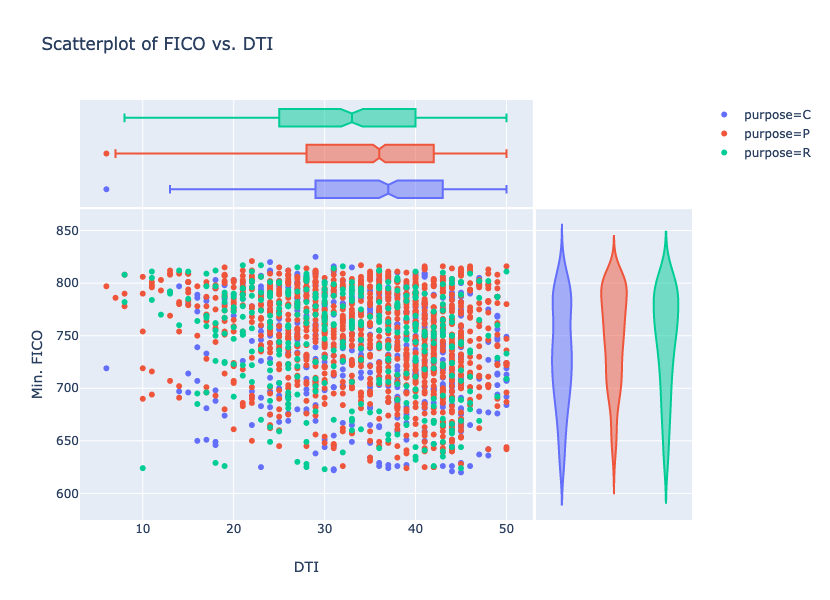

In [22]:
# quick test of plotly express

# make a much smaller sub-sampled df for test viz
test_viz_df = acq_2017_df.sample(frac=0.001)

px.scatter(
    data_frame=test_viz_df, 
    x='dti', 
    y='cscore_min', 
    color='purpose',
    marginal_y='violin',
    marginal_x='box',
    title="Scatterplot of FICO vs. DTI",
    labels=dict(cscore_min = "Min. FICO", dti="DTI")
)

In [23]:
5+5

10